In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import tree, preprocessing
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split

import geopandas as gpd

<AxesSubplot:>

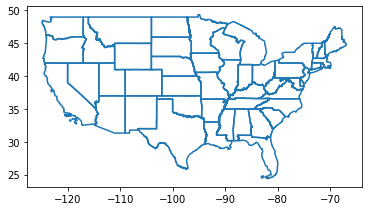

In [2]:
usa = gpd.read_file('map_usa/tl_2022_us_state.shp')
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
for n in non_continental:
    usa = usa[usa.STUSPS != n]
usa.boundary.plot()


In [23]:
california = usa[usa.STUSPS == 'CA']

In [5]:
filepath = "data/fire_archive_SV-C2_390000.shp"

gdf = gpd.read_file(filepath)

In [6]:
gdf_2015 = gdf[gdf['ACQ_DATE'].str.contains('2015')]

In [7]:
gdf_2015

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
772889,40.751339,-81.441330,335.88,0.45,0.63,2015-01-01,0630,N,VIIRS,n,1,264.78,3.99,N,0,POINT (-81.44133 40.75134)
772890,39.937538,-76.812614,301.80,0.51,0.49,2015-01-01,0630,N,VIIRS,n,1,267.25,0.80,N,2,POINT (-76.81261 39.93754)
772891,40.126335,-80.997078,322.99,0.42,0.61,2015-01-01,0630,N,VIIRS,n,1,265.49,3.26,N,0,POINT (-80.99708 40.12633)
772892,38.956635,-81.926811,296.65,0.47,0.64,2015-01-01,0630,N,VIIRS,n,1,265.54,1.06,N,0,POINT (-81.92681 38.95663)
772893,38.950653,-81.927086,295.98,0.47,0.64,2015-01-01,0630,N,VIIRS,n,1,264.12,1.06,N,0,POINT (-81.92709 38.95065)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350006,34.279835,-109.076752,341.52,0.43,0.46,2015-12-31,2042,N,VIIRS,n,1,283.17,5.39,D,0,POINT (-109.07675 34.27983)
1350007,35.962158,-112.155090,342.05,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,276.36,5.56,D,0,POINT (-112.15509 35.96216)
1350008,35.965832,-112.155701,338.68,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,274.28,7.17,D,0,POINT (-112.15570 35.96583)
1350009,35.651077,-120.605408,334.89,0.48,0.40,2015-12-31,2042,N,VIIRS,n,1,288.17,4.90,D,0,POINT (-120.60541 35.65108)


In [8]:
perimeters = gpd.read_file('data/perimeters/US_HIST_FIRE_PERIM_2015_DD83.shp')

In [43]:
from datetime import datetime

check_df_1 = perimeters['datecurren'].dropna()
check_df_2 = perimeters['perimeterd'].dropna()

full = check_df_1.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d')) -  check_df_2.astype(str).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


In [9]:
print(gdf_2015.crs)
print(perimeters.crs)

EPSG:4326
EPSG:4326


In [10]:
joined = gpd.sjoin(gdf_2015, perimeters, how="inner", op="within")


/Users/lucasrosenblatt/opt/miniconda3/envs/heuristic_fairness/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [11]:
joined.columns

Index(['LATITUDE', 'LONGITUDE', 'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE',
       'ACQ_TIME', 'SATELLITE', 'INSTRUMENT', 'CONFIDENCE', 'VERSION',
       'BRIGHT_T31', 'FRP', 'DAYNIGHT', 'TYPE', 'geometry', 'index_right',
       'FID', 'agency', 'comments', 'active', 'mapmethod', 'datecurren',
       'uniquefire', 'fireyear', 'incidentna', 'pooownerun', 'perimeterd',
       'gisacres', 'complexnam', 'firecode', 'complexpar', 'poorespons',
       'state', 'inciwebid', 'localincid', 'irwinid', 'incomplex',
       'complexfir', 'latest', 'SHAPE_Leng', 'SHAPE_Area'],
      dtype='object')

ConversionError: Failed to convert value(s) to axis units: '2015-09-13'

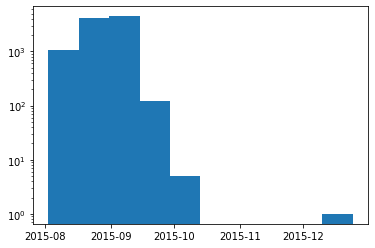

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# joined[joined['FID'] == 13][['date_time']].hist(ax=ax, log=True)
ax.hist(joined[joined['FID'] == 13][['date_time']], log=True)
# add vertical line at perimeter date
plt.axvline(x=perimeters[perimeters['FID'] == 13]['perimeterd'].iloc[0], color='k', linestyle='--')

plt.show()

In [80]:
joined['FID']

775602      138
1113520     138
1113521     138
1113522     138
1113523     138
           ... 
1349088    7454
1349089    7454
1349091    7454
1349133    7454
1349135    7454
Name: FID, Length: 6636309, dtype: int64

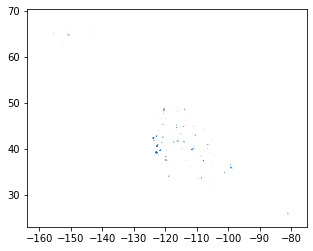

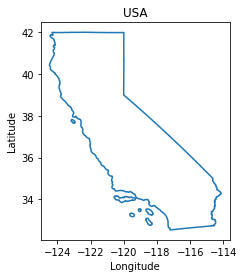

In [24]:
perimeters.plot()
california.boundary.plot()
plt.title('USA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
joined['ACQ_TIME'] = joined['ACQ_TIME'].astype(str).str.zfill(4)
joined['ACQ_TIME'] = joined['ACQ_TIME'].str[:2] + ':' + joined['ACQ_TIME'].str[2:]
joined['date_time'] = pd.to_datetime(joined['ACQ_DATE'] + ' ' + joined['ACQ_TIME'])

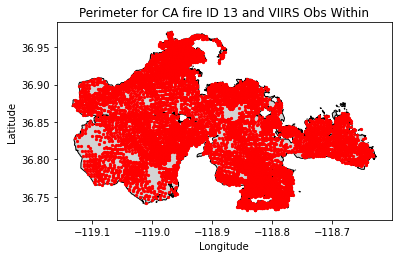

In [76]:
fid = 13

specific_perimeter = perimeters[perimeters['FID'] == fid]

points_within = joined[joined['FID'] == fid]

fig, ax = plt.subplots()

specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')

points_within.plot(ax=ax, markersize=5, color='red')

plt.title(f"Perimeter for CA fire ID {fid} and VIIRS Obs Within")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


<AxesSubplot:>

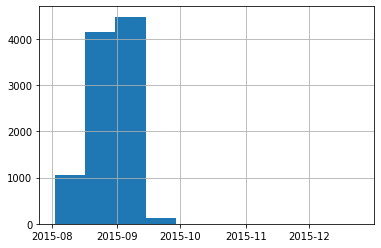

In [75]:
# hist plot of the date_time columns
points_within.date_time.hist()

In [9]:
def efficient_filter(group):
    # Sort group by date_time
    group = group.sort_values('date_time')
    
    # Calculate difference with the next and previous date for each row
    diff_next = group['date_time'].diff(-1).abs().dt.days
    diff_prev = group['date_time'].diff().abs().dt.days
    
    # Check if the time difference is within the threshold (5 days in this case)
    within_threshold = ((diff_next <= 5) | (diff_prev <= 5))
    
    return group[within_threshold]

# Group by FID and apply the efficient_filter function
filtered_df = joined.groupby('FID').apply(efficient_filter)

# Reset the index of the result
filtered_df = filtered_df.reset_index(drop=True)


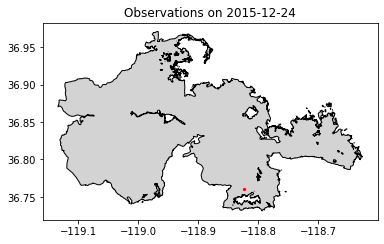

In [79]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

days = points_within['date_time'].dt.date.unique()

fig, ax = plt.subplots()

specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')

def animate(day):
    ax.clear()
    
    specific_perimeter.plot(ax=ax, color='lightgray', edgecolor='black')
    
    day_points = points_within[points_within['date_time'].dt.date == day]
    day_points.plot(ax=ax, markersize=5, color='red')
    
    ax.set_title(f"Observations on {day}")

ani = animation.FuncAnimation(fig, animate, frames=days, repeat=False, interval=1000)

ani.save('animated_fire_obs.gif', writer='pillow', fps=1)

